In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

imdb = "/content/gdrive/My Drive/IMDB Dataset_bert_210219.csv"

In [ ]:
import pickle as pc
import os
import numpy as np
import csv
import torch

print("Pytorch Version: ", torch.__version__)

if torch.cuda.is_available():

    device = torch.device("cuda")
    
    print("There are %d GPU(s) available." % torch.cuda.device_count())
    print("We will use the GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

Pytorch Version:  1.8.0+cu101
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [ ]:
def load_data(filename):
    data = list()
    label = list()
    
    f = open(filename, 'r', encoding='latin1')
    reader = csv.reader(f)
    for idx, line in enumerate(reader):
        if idx == 0:
            continue

        data.append(line[0])
        label.append(int(line[2]))

    f.close()

    assert len(data) == len(label)
    return data, label

In [ ]:
imdb_data, imdb_label = load_data(imdb)

In [ ]:
print("Size of imdb data: {}".format(len(imdb_data)))
print("Size of imdb label: {}".format(len(imdb_label)))

Size of imdb data: 50000
Size of imdb label: 50000


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_label, test_label = train_test_split(imdb_data, imdb_label, test_size = 0.2, random_state = 42)

In [ ]:
print("Size of train data: {}".format(len(train_data)))
print("Size of train label: {}".format(len(train_label)))

Size of train data: 40000
Size of train label: 40000


In [ ]:
import numpy as np
test_data = np.array(test_data)
test_label = np.array(test_label)

In [ ]:
from transformers import BertTokenizer

print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
print("Original: ", train_data[0])
print()

print("Tokenized: ", tokenizer.tokenize(train_data[0]))
print()

print("Token IDs: ", tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_data[0])))
print()

Original:  That's what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I'm not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine's slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don't know what acting school they graduated from, but if I was them I'd apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we'll probably never hear from again. At least, that's the hope.

In [ ]:
input_ids = []

for sent in train_data:
    
    encoded_sent = tokenizer.encode(sent, 
                                    add_special_tokens=True,
                                    max_length = 256)
 
    input_ids.append(encoded_sent)

print("Original: ", train_data[0])
print()
print("Token IDs: ", input_ids[0])

print("\n[CLS] token: {:}, ID: {:}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("\n[PAD] token: {:}, ID: {:}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("\n[SEP] token: {:}, ID: {:}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("\nTokenized: ", tokenizer.convert_ids_to_tokens(input_ids[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  That's what I kept asking myself during the many fights, screaming matches, swearing and general mayhem that permeate the 84 minutes. The comparisons also stand up when you think of the one-dimensional characters, who have so little depth that it is virtually impossible to care what happens to them. They are just badly written cyphers for the director to hang his multicultural beliefs on, a topic that has been done much better in other dramas both on TV and the cinema.<br /><br />I must confess, I'm not really one for spotting bad performances during a film, but it must be said that Nichola Burley (as the heroine's slutty best friend) and Wasim Zakir (as the nasty, bullying brother) were absolutely terrible. I don't know what acting school they graduated from, but if I was them I'd apply for a full refund post haste. Only Samina Awan in the lead role manages to impress in a cast of so-called British talent that we'll probably never hear from again. At least, that's the hope.

In [ ]:
print("Max length: ", max([len(each) for each in input_ids]))

Max length:  256


In [ ]:
import tensorflow as tf
print("Tensorflow version: {}".format(tf.__version__))

MAXLEN = 256

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, 
                                                          maxlen=MAXLEN, dtype="long", value=0, truncating="post", padding="post")

print("\nDone.")

Tensorflow version: 2.4.1

Done.


In [ ]:
attention_masks = []

for sent in input_ids:

    att_mask = [int(token_id > 0) for token_id in sent]

    attention_masks.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_label, random_state=2018, test_size=0.1)

train_masks, valid_masks, _, _ = train_test_split(attention_masks, train_label, random_state=2018, test_size=0.1)

print(train_inputs[:1])
print(train_masks[:1])

[[  101  1045  1005  2310  3866  2023  3185  2144  1996  2034  2051  1045
   2387  2009  8840  2122  2116  2086  3283  1012  1045  1005  1049  2025
   2469  2129  2116  2335  1045  1005  2310  2464  2009  1010  3383  2184
   1010  3383  2322  1012  2023  2197  2051  1045  3427  2009  1045  2001
   4930  2011  1037  6987  2008  1045  2910  1005  1056  4384  2077  1012
   1026  7987  1013  1028  1026  7987  1013  1028  2646  1996  2203  1997
   1996  3861  1010  1996 19668  7348  2024 21527  2067  2000  1996  2237
   3081 22889  2098  1012  2045  2024  1037  3232  1997  2485 22264  1997
   1996  2757  2273  1012  1996  2028  2008  4930  2033  2087  2001  1037
   2915  1997  1996  8855  3360  1012  2035  2017  2156  2006  1996  3898
   2003  2010  6337  2013  2132  2000  2398  1012  2010  2398  2024  3173
   1037 20046 13541  1012  1996  3612  2003 11221  1998  2010  4317  8855
   2606  2003  5613  1999  1996  3612  1010  1999  8694  2007  1996 17909
   1997  1996 13541  8457  1012  1996 

In [ ]:
train_inputs = torch.tensor(train_inputs)
valid_inputs = torch.tensor(valid_inputs)

train_labels = torch.tensor(train_labels)
valid_labels = torch.tensor(valid_labels)

train_masks = torch.tensor(train_masks)
valid_masks = torch.tensor(valid_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels = 2, 
                                                                      
                                                      output_attentions = False, 
                                                      output_hidden_states = False) 

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

print(len(train_dataloader))
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

1125


In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=-1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round(elapsed))

    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [ ]:
seed_val = 42
set_seed(seed_val)

loss_values = []

for epoch in range(0, epochs):
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
    print('Training...')
   
    t0 = time.time()
    
    total_loss = 0.
    
    model.train()

    for step, batch in enumerate(train_dataloader):
        
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            
            print("Batch {:>5,} of {:>5,}. Elapsed: {:}.".format(step, len(train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        model.zero_grad()
        
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        total_loss += loss.item()

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
              
        optimizer.step()
        
        scheduler.step()
    
    avg_train_loss = total_loss / len(train_dataloader)
    
    loss_values.append(avg_train_loss)
    
    print("")
    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(format_time(time.time() - t0)))
    
    print("")
    print("Running Validation...")
    
    t0 = time.time()
    
    model.eval()
    
    eval_loss, eval_acc = 0., 0.
    
    for valid_step, batch in enumerate(valid_dataloader):
        
        batch = tuple(t.to(device) for t in batch)
        
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            
        logits = outputs[0]
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_acc = flat_accuracy(logits, label_ids)
        
        eval_acc += tmp_eval_acc        
    
    print("Accuracy: {0:.2f}".format(eval_acc / (valid_step + 1)))
    print("Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")        


======== Epoch 1 / 4 ========
Training...
Batch    40 of 1,125. Elapsed: 0:00:56.
Batch    80 of 1,125. Elapsed: 0:02:00.
Batch   120 of 1,125. Elapsed: 0:03:05.
Batch   160 of 1,125. Elapsed: 0:04:09.
Batch   200 of 1,125. Elapsed: 0:05:14.
Batch   240 of 1,125. Elapsed: 0:06:19.
Batch   280 of 1,125. Elapsed: 0:07:23.
Batch   320 of 1,125. Elapsed: 0:08:28.
Batch   360 of 1,125. Elapsed: 0:09:32.
Batch   400 of 1,125. Elapsed: 0:10:37.
Batch   440 of 1,125. Elapsed: 0:11:42.
Batch   480 of 1,125. Elapsed: 0:12:47.
Batch   520 of 1,125. Elapsed: 0:13:52.
Batch   560 of 1,125. Elapsed: 0:14:56.
Batch   600 of 1,125. Elapsed: 0:16:01.
Batch   640 of 1,125. Elapsed: 0:17:06.
Batch   680 of 1,125. Elapsed: 0:18:11.
Batch   720 of 1,125. Elapsed: 0:19:16.
Batch   760 of 1,125. Elapsed: 0:20:21.
Batch   800 of 1,125. Elapsed: 0:21:26.
Batch   840 of 1,125. Elapsed: 0:22:31.
Batch   880 of 1,125. Elapsed: 0:23:35.
Batch   920 of 1,125. Elapsed: 0:24:40.
Batch   960 of 1,125. Elapsed: 0:25:4

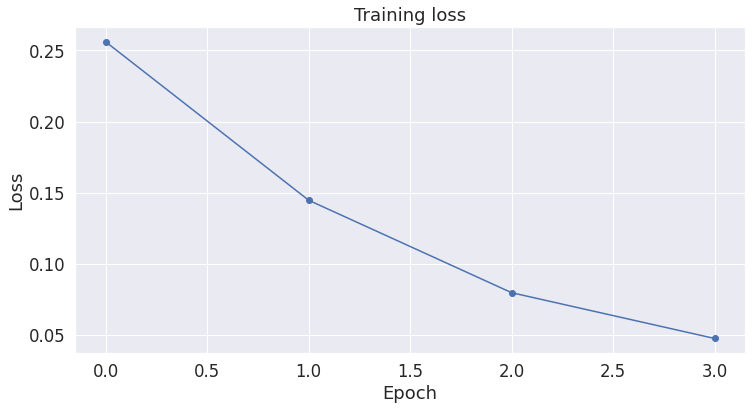

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o')

plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [ ]:
input_ids = []

for sent in test_data:
    encoded_sent = tokenizer.encode(
                        sent,                      
                        add_special_tokens = True, 
                   )
    
    input_ids.append(encoded_sent)

input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=MAXLEN, 
                          dtype="long", truncating="post", padding="post")

attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    
    attention_masks.append(att_mask)

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_label)
 
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (798 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs[0]

  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.extend(np.argmax(logits, axis=1).flatten())
  true_labels.extend(label_ids.flatten())


print('DONE.')

Predicting labels for 10,000 test sentences...
DONE.


In [ ]:
from sklearn.metrics import classification_report
    
target_names = ['negative', 'positive']

print(classification_report(true_labels, predictions, digits=4, target_names=target_names))

              precision    recall  f1-score   support

    negative     0.9398    0.8805    0.9091      4961
    positive     0.8892    0.9444    0.9160      5039

    accuracy                         0.9127     10000
   macro avg     0.9145    0.9125    0.9126     10000
weighted avg     0.9143    0.9127    0.9126     10000

